In [1]:
import numpy as np
from scipy import optimize, stats

In [2]:
from astropy.table import Table, QTable
from astropy.time import Time
from astropy import units as u
from astropy import constants as cnst

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

The data are in the github repository for where this notebook is posted, so the local copy is preferred if you've cloned the repo.  But you can uncommend the second line if you are accessing this notebook directly and want the original source of the data.

In [4]:
data_name = 'sam_flight_data_feb18.csv'
#data_name = 'https://docs.google.com/spreadsheets/d/1Onn-4OYDuTSbTe9kPB9I9oyuBzWMQiNiDGXlQYIAFUE/export?format=csv'

The spreadsheet has multiple columns with the same name.  Astropy tables by design do not allow this, but pandas does.  So we use the pandas csv reader to load in the data, but then switch to astropy because it can have physical units in the table columns.

In [5]:
#QTable.read(data_name, format='csv')

In [6]:
import pandas as pd
ptab = pd.read_csv(data_name)

In [7]:
tab = QTable.from_pandas(ptab)

t = Time(['2018-2-11 '+t for t in tab['time']])
del tab['time']
tab['time'] = t
tab['dt'] = (t-t[0]).to(u.second)

tab['velocity'].mask[0] = True  # for some reason the initial one is NaN...

tab

_sentence,_receivers,count_receivers,sentence_id,time difference,latitude,longitude,altitude,velocity,acceleration,satellites,temperature_external,pressure,humidity,temperature_internal (raw),temperature_internal (corrected),sentence_id.1,nofix,time.1,satellites.1,temperature_external.1,pressure.1,humidity.1,uptime,temperature_internal,time,dt
,,,,,,,,,,,,,,,,,,,,,,,,,,s
str79,str104,int64,int64,str7,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,str8,int64,float64,float64,float64,float64,float64,object,float64
"$$SAM,182,14:15:48,51.950855,-2.548398,127,9,8.15,992.0,47.47,15.0*6427",trickv,1,182,--,51.950855,-2.548398,127,--,--,9,8.15,992.0,47.47,15.0,15.0,182,--,14:15:48,9,8.15,992.0,47.47,--,15.0,2018-02-11 14:15:48.000,0.0
"$$SAM,183,14:16:04,51.950875,-2.548439,126,12,6.74,991.91,50.23,14.75*3ED7",trickv,1,183,0:00:16,51.950875,-2.548439,126,-0.06,--,12,6.74,991.91,50.23,14.75,14.75,183,--,14:16:04,12,6.74,991.91,50.23,--,14.75,2018-02-11 14:16:04.000,15.999999999999304
"$$SAM,184,14:16:22,51.950892,-2.548448,126,12,6.36,992.17,52.44,14.25*2D9A",trickv,1,184,0:00:18,51.950891999999996,-2.548448,126,0.0,0.0625,12,6.36,992.17,52.44,14.25,14.25,184,--,14:16:22,12,6.36,992.17,52.44,--,14.25,2018-02-11 14:16:22.000,34.00000000000212
"$$SAM,185,14:16:38,51.950882,-2.548442,124,12,7.02,992.17,50.53,14.25*C188",trickv,1,185,0:00:16,51.950882,-2.5484419999999997,124,-0.13,-0.13,12,7.02,992.17,50.53,14.25,14.25,185,--,14:16:38,12,7.02,992.17,50.53,--,14.25,2018-02-11 14:16:38.000,50.00000000000142
"$$SAM,186,14:16:54,51.950893,-2.548429,121,12,6.73,992.15,49.43,14.125*5BB7",trickv,1,186,0:00:16,51.950893,-2.548429,121,-0.19,-0.06,12,6.73,992.15,49.43,14.125,14.125,186,--,14:16:54,12,6.73,992.15,49.43,--,14.125,2018-02-11 14:16:54.000,66.00000000000072
"$$SAM,187,14:17:11,51.950884,-2.54844,123,12,6.55,991.9,52.11,14.0*9066",trickv,1,187,0:00:17,51.950884,-2.5484400000000003,123,0.12,0.31,12,6.55,991.9,52.11,14.0,14.0,187,--,14:17:11,12,6.55,991.9,52.11,--,14.0,2018-02-11 14:17:11.000,83.00000000000658
"$$SAM,188,14:17:27,51.950872,-2.548393,122,12,7.28,992.16,50.77,14.0*F229",trickv,1,188,0:00:16,51.950872,-2.548393,122,-0.06,-0.18,12,7.28,992.16,50.77,14.0,14.0,188,--,14:17:27,12,7.28,992.16,50.77,--,14.0,2018-02-11 14:17:27.000,99.00000000000588
"$$SAM,189,14:17:43,51.950882,-2.548405,120,12,7.29,991.87,49.19,13.875*6FF7",trickv,1,189,0:00:16,51.950882,-2.548405,120,-0.13,-0.06,12,7.29,991.87,49.19,13.875,13.875,189,--,14:17:43,12,7.29,991.87,49.19,--,13.875,2018-02-11 14:17:43.000,115.00000000000519


In [8]:
tab['altitude'].unit = u.m
tab['velocity'].unit = u.m/u.s
tab['pressure'].unit = u.hPa
tab['temperature_external'].unit = u.deg_C

Text(0, 0.5, 'velocity [m / s]')

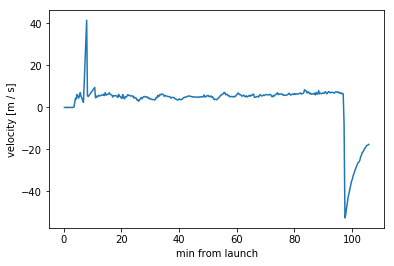

In [9]:
plt.plot(tab['dt'].to(u.min), tab['velocity'])
plt.xlabel('min from launch')
plt.ylabel('velocity [{}]'.format(tab['velocity'].unit))

Text(0, 0.5, 'temp [K]')

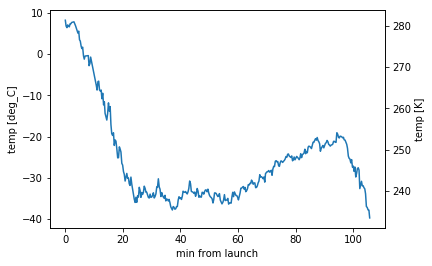

In [10]:
plt.plot(tab['dt'].to(u.min), tab['temperature_external'])
plt.xlabel('min from launch')
plt.ylabel('temp [{}]'.format(tab['temperature_external'].unit))
deg1, deg2 = plt.ylim()

plt.twinx()
plt.ylim((deg1*u.deg_C).to(u.K, u.temperature()).value, (deg2*u.deg_C).to(u.K, u.temperature()).value)
plt.ylabel('temp [K]')

Text(0, 0.5, 'humidity [%]')

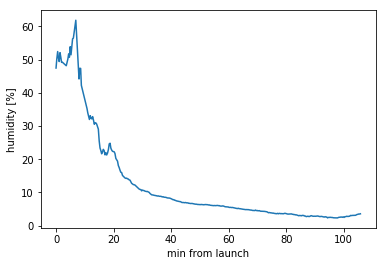

In [11]:
plt.plot(tab['dt'].to(u.min), tab['humidity'])
plt.xlabel('min from launch')
plt.ylabel('humidity [%]')

Text(0, 0.5, 'pressure [hPa]')

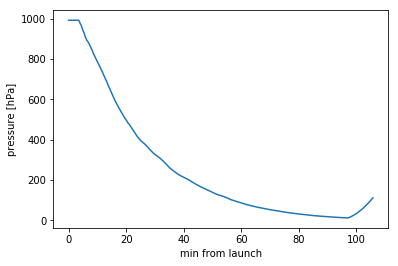

In [12]:
plt.plot(tab['dt'].to(u.min), tab['pressure'])
plt.xlabel('min from launch')
plt.ylabel('pressure [{}]'.format(tab['pressure'].unit))

Text(0, 0.5, 'altitude [m]')

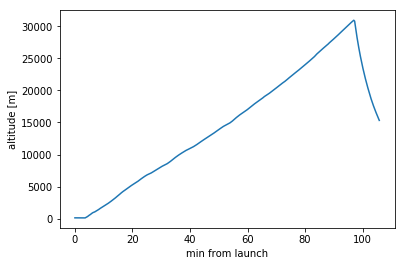

In [13]:
plt.plot(tab['dt'].to(u.min), tab['altitude'])
plt.xlabel('min from launch')
plt.ylabel('altitude [{}]'.format(tab['altitude'].unit))

For following plots its useful to distinguish from "up-going" (positive velocity) and "down-going" (post-ballon burst) segments of the flight.

In [14]:
posv = tab['velocity']>(-10*u.m/u.s) # a few glitches go slightly neg at the start
posv[0] = True  # also the first velocity is NaN but we assign it to "up-going"

/home/erik/miniconda3/envs/anaconda/lib/python3.6/site-packages/astropy/units/quantity.py:461: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Text(0, 0.5, 'temperature [deg_C]')

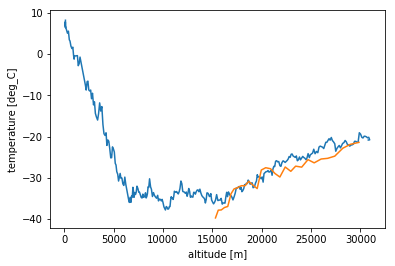

In [15]:
plt.plot(tab['altitude'][posv], tab['temperature_external'][posv])
plt.plot(tab['altitude'][~posv], tab['temperature_external'][~posv])

plt.xlabel('altitude [{}]'.format(tab['altitude'].unit))
plt.ylabel('temperature [{}]'.format(tab['temperature_external'].unit))

Text(0, 0.5, 'pressure [hPa]')

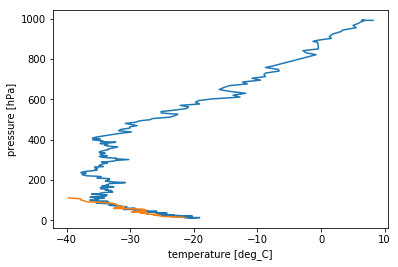

In [16]:
plt.plot(tab['temperature_external'][posv], tab['pressure'][posv])
plt.plot(tab['temperature_external'][~posv], tab['pressure'][~posv])
plt.xlabel('temperature [{}]'.format(tab['temperature_external'].unit))
plt.ylabel('pressure [{}]'.format(tab['pressure'].unit))

Text(0, 0.5, 'pressure [hPa]')

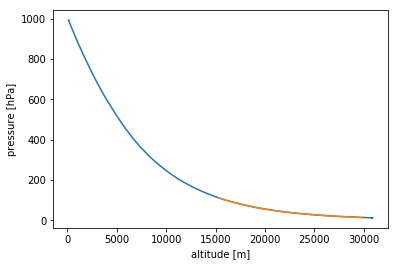

In [17]:
plt.plot(tab['altitude'][posv], tab['pressure'][posv])
plt.plot(tab['altitude'][~posv], tab['pressure'][~posv])

plt.xlabel('altitude [{}]'.format(tab['altitude'].unit))
plt.ylabel('pressure [{}]'.format(tab['pressure'].unit))

## What is the scale height of the atmosphere? 

From thermo, we know this is the theoretical expectation:

$\ell = \frac{kT}{\mu m_p g}$

where $k_b$ is Boltzmann's constant, $T$ is the temperature, $m_p$ is the proton mass, $\mu$ is the mean molecular mass (in units of $m_p$ ~ amu), $g$ is the gravitational acceleration

In [18]:
scale_height = lambda T, mu: (cnst.k_B * T / (mu*cnst.m_p*cnst.g0)).to(u.m)

Assume Earth atmosphere is 78% N, 21% O, 1% Argon:

In [19]:
m_N = 14*2
m_O = 16*2
m_Ar = 40

mu_guess = np.average([m_N, m_O, m_Ar], weights=[.78,.21, .01])
mu_guess

28.959999999999997

Guess the avg temp to be the mean:

In [20]:
avgT = np.mean(tab['temperature_external'].to(u.K, u.temperature()))
avgT

<Quantity 246.8897479 K>

In [21]:
scale_height(avgT, mu_guess)

<Quantity 7175.78101102 m>

<Quantity 7050.76875092 m>

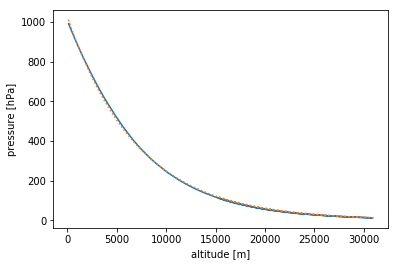

In [22]:
def pressure_model(alt, p):
    A, l = p
    return A* np.exp(-alt.value/l)

def resid(p, *args):
    obs_altitude, obs_pressure = args
    return pressure_model(obs_altitude, p) - obs_pressure.value

Aopt, lopt = optimize.leastsq(resid, (1000, 10000), args=(tab['altitude'], tab['pressure']))[0]

plt.plot(tab['altitude'], tab['pressure'])
plt.plot(tab['altitude'], pressure_model(tab['altitude'], (Aopt, lopt)), ls=':')
plt.xlabel('altitude [{}]'.format(tab['altitude'].unit))
plt.ylabel('pressure [{}]'.format(tab['pressure'].unit))

Aopt = Aopt*tab['pressure'].unit
lopt = lopt*tab['altitude'].unit
lopt

(-15, 20)

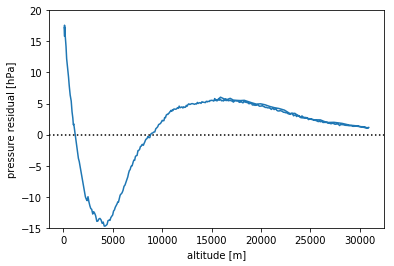

In [23]:
plt.plot(tab['altitude'], pressure_model(tab['altitude'], (Aopt.value, lopt.value))-tab['pressure'].value)
plt.xlabel('altitude [{}]'.format(tab['altitude'].unit))
plt.ylabel('pressure residual [{}]'.format(tab['pressure'].unit))
plt.axhline(0, c='k', ls=':')
plt.ylim(-15, 20)

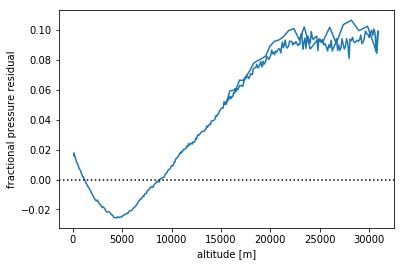

In [24]:
plt.plot(tab['altitude'], pressure_model(tab['altitude'], (Aopt.value, lopt.value))/tab['pressure'].value-1)

plt.xlabel('altitude [{}]'.format(tab['altitude'].unit))
plt.ylabel('fractional pressure residual'.format(tab['pressure'].unit))
plt.axhline(0, c='k', ls=':')

In [25]:
res = resid((Aopt.value, lopt.value), tab['altitude'], tab['pressure'])
chi2 = np.sum(res**2/np.var(res))
dof = len(res) - 2
rchi2 = chi2/dof
stats.chi2(dof).cdf(chi2), rchi2

(0.8299010605674478, 1.0713514596482405)

Looks like a fairly reasonable fit... and it's pretty darn close to the theoretical estimate!

### Alternate formulation

We could probably do better by using a model where the scale height is *predicted* by the temperature... and *predict* the mean molecular mass:

(<Quantity 1011.24651398 hPa>, 28.562230276556022)

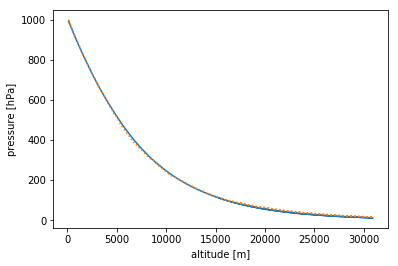

In [26]:
def pressure_model(alt, T, p):
    A, mu = p
    l = scale_height(T, mu).to(u.m)
    return A* np.exp(-alt/l).value

def resid(p, *args):
    obs_altitude, obs_pressure, obs_temperature = args
    return pressure_model(obs_altitude, obs_temperature, p) - obs_pressure.value

alt = tab['altitude']
P = tab['pressure']
T =  tab['temperature_external'].to(u.K, u.temperature())

Aopt, muopt = optimize.leastsq(resid, (1000, 40), args=(alt, P, T))[0]

plt.plot(alt, P)
plt.plot(alt, pressure_model(alt, T, (Aopt, muopt)), ls=':')
plt.xlabel('altitude [{}]'.format(tab['altitude'].unit))
plt.ylabel('pressure [{}]'.format(tab['pressure'].unit))


Aopt = Aopt*tab['pressure'].unit

Aopt, muopt

(-15, 20)

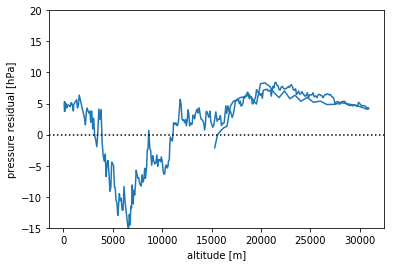

In [27]:
plt.plot(alt, pressure_model(alt, T, (Aopt, muopt))-P)
plt.xlabel('altitude [{}]'.format(tab['altitude'].unit))
plt.ylabel('pressure residual [{}]'.format(tab['pressure'].unit))
plt.axhline(0, c='k', ls=':')
plt.ylim(-15, 20)

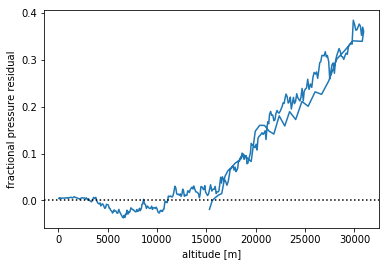

In [28]:
plt.plot(alt, pressure_model(alt, T, (Aopt, muopt))/P-1)
plt.xlabel('altitude [{}]'.format(tab['altitude'].unit))
plt.ylabel('fractional pressure residual'.format(tab['pressure'].unit))
plt.axhline(0, c='k', ls=':')

In [29]:
res = resid((Aopt.value, muopt), alt, P, T)
chi2 = np.sum(res**2/np.var(res))
dof = len(res) - 2
rchi2 = chi2/dof
stats.chi2(dof).cdf(chi2), rchi2

(0.9758928513083246, 1.1536531688742686)